# Calibration for Yield Curve

We got Instanteneous Forward Rates for AAA rated bonds from ECB:
https://www.ecb.europa.eu/stats/financial_markets_and_interest_rates/euro_area_yield_curves/html/index.en.html

And we get the initial Interest Rate from here:
https://www.ecb.europa.eu/stats/policy_and_exchange_rates/key_ecb_interest_rates/html/index.en.html

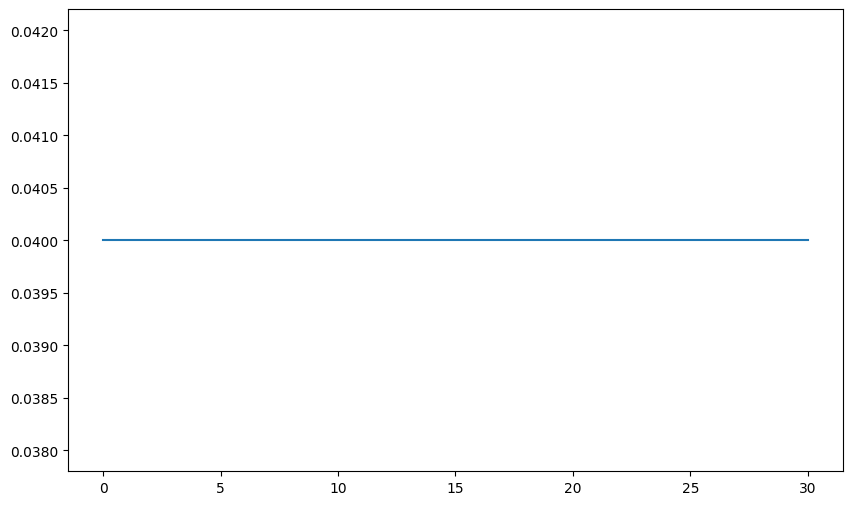

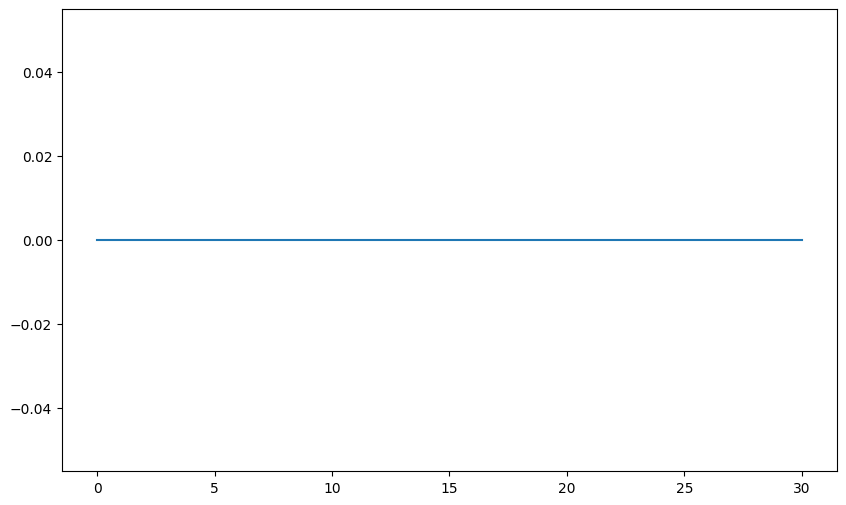

In [130]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import CubicSpline
import scipy.stats as stats

# Interest Rates
r0 = .04
# ECB Market Yield Curve on 7th November 2023 (Humped)
market_yields = [
    (0.25, .03708004),
    (0.50, .03480834),
    (0.75, .03205257),
    (1.0, .02944257),
    (2.0, .02342641),
    (3.0, .02264375),
    (4.0, .02372672),
    (5.0, .02519909),
    (6.0, .02661483),
    (7.0, .02786643),
    (8.0, .02894020),
    (9.0, .02984566),
    (10.0, .03059704),
    (11.0, .03120873),
    (12.0, .03169425),
    (13.0, .03206610),
    (14.0, .03233577),
    (15.0, .03251381),
    (16.0, .03260989),
    (17.0, .03263287),
    (18.0, .03259087),
    (19.0, .03249129),
    (20.0, .03234093),
    (21.0, .03214597),
    (22.0, .03191205),
    (23.0, .03164432),
    (24.0, .03134746),
    (25.0, .03102571),
    (26.0, .03068293),
    (27.0, .03032262),
    (28.0, .02994794),
    (29.0, .02956175),
    (30.0, .02916661),
]
# Flat Yield Curve
flat_yields = [
    (0.5, .04),
    (2.0, .04),
    (5.0, .04),
    (10.0, .04),
]
# Normal(Upward) Yield Curve
upward_yields = [
    (0.25, .041),
    (1.0, .042),
    (2.0, .043),
    (4.0, .044),
    (8.0, .0452),
    (12.0, .046),
    (24.0, .047),
    (30.0, .0471),
]
# Inverted Yield Curve
downward_yield = [
    (0.25, .039),
    (1.0, .038),
    (2.0, .037),
    (4.0, .036),
    (8.0, .0348),
    (12.0, .034),
    (24.0, .033),
    (30.0, .0329),
]

# Extract durations and yields
yield_curve = downward_yield
durations = [item[0] for item in flat_yields]
yields = [item[1] for item in flat_yields]

# Fit cubic spline
yield_curve = CubicSpline(durations, yields)

# Visualize the Fitted Curve
maturities = np.linspace(0.0, 30, 100)    # Generate 100 points (maturity time points) between 0.0 and 30.0
fitted_yields = yield_curve(maturities)   # Get the corresponding yields to maturity
plt.figure(1, figsize=(10,6))
plt.plot(maturities, fitted_yields)

# Visualize the Fitted Curve dt
maturities = np.linspace(0.0, 30, 100)    # Generate 100 points (maturity time points) between 0.0 and 30.0
fitted_yields_dt = yield_curve.derivative(nu=1)(maturities)   # Get the corresponding yields to maturity
plt.figure(2, figsize=(10,6))
plt.plot(maturities, fitted_yields_dt)
# To Be continued

# Hull-White (One Factor Model)

Assumptions:
1. Speed of reversion is constant $\alpha$, to be obtained from current market structure
2. Volatility is constant $\sigma$, to be obtained from current market structure
3. Reversion level is time dependent, $\theta(t)$ is chosen to make the model consistent with the initial term structure, which we get from ECB yield curve.


$$
dr(t) = \alpha[\frac{\theta(t)}{\alpha}-r(t)]dt + \sigma dW(t)
$$

$$
\theta(t)=F_t(0, t)+a F(0, t)+\frac{\sigma^2}{2 a}\left(1-e^{-2 a t}\right)
$$
Where $F$ is market's instanteneous rate and $F_t$ is its derivative.


In [131]:
# Simulation's Parameters
T = 10                  # Years of Simulation
days_per_year = 365     # Days in the Year
N = int(T*days_per_year)     # Number of steps
dt = 1.0 * T / N        # Time step size
simulations = 10_000        # Amount of Monte Carlo runs
#np.random.seed(42)

# Parameters for the Hull-White model
a = 0.1       # Just some value
sigma = 0.002   # Assumed 250bps (to make things interesting)
theta = lambda t: yield_curve.derivative(nu=1)(t) + (a*yield_curve(t)) + ((sigma**2)/(2*a))*(1-np.exp(-2*a*t))
r0 = 0.04

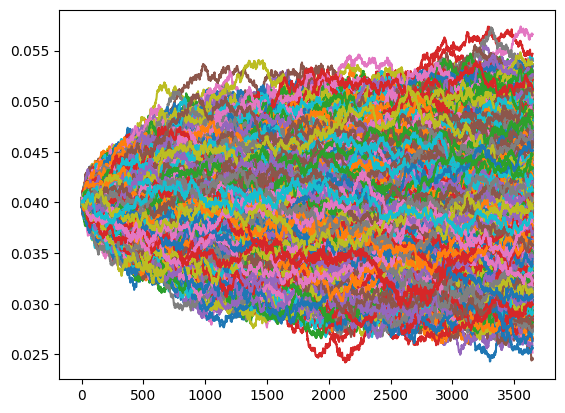

In [132]:
import numpy as np
import matplotlib.pyplot as plt
from multiprocess import Pool


# I decided not to implement vectorized explicit formula (integrals still need for loop), so I parallelyzed drift generator
# Define the function that simulates a single path
def simulate_path(params):

    import numpy as np
    from scipy.interpolate import CubicSpline
    import scipy.stats as stats

    _, N, dt, r0, a, sigma, theta, yield_curve = params
    theta = lambda t: yield_curve.derivative(nu=1)(t) + (a*yield_curve(t)) + ((sigma**2)/(2*a))*(1-np.exp(-2*a*t))
    
    Z = np.random.normal(0, 1, N)
    dr = np.zeros(N)
    r = np.zeros(N)
    r[0] = r0  # Initialize with the initial rate from the market
    for t in range(1, N):
        dr[t] = (theta(t * dt) - a * r[t-1]) * dt + sigma * np.sqrt(dt) * Z[t]
        r[t] = r[t-1] + dr[t]
    return r

# Use multiprocess to run simulations in parallel
simulation_params = [(i, N, dt, r0, a, sigma, theta, yield_curve) for i in range(simulations)]

# Run in Parallel
with Pool() as pool:
    short_rate_paths = pool.map(simulate_path, simulation_params)

# Convert list of arrays to a 2D NumPy array
short_rate_paths = np.array(short_rate_paths)

# Plotting the paths
plt.plot(short_rate_paths.T)
plt.show()


## Analytical Verification

For Hull-White model we have an analytical solution for both mean and variance of short-rates at any $t$ as observed from $t=0$. These are: 
$$
\begin{aligned}
\mathbb{E}^Q\left(r(t) \mid \mathcal{F}_0\right) & =r(0) e^{a(0-t)}+\int_0^t e^{a(u-t)} \theta(u) d u \\
\operatorname{Var}\left(r(t) \mid \mathcal{F}_0\right) &=\frac{\sigma^2}{2 a}\left(1-e^{2 a(0-t)}\right)
\end{aligned}
$$

In [133]:
analytical_short_rates = []
for t in np.linspace(0, T, N):
    integral = 0
    for u in np.linspace(0, t, int(t*days_per_year)):
        integral += np.exp(a*(u-t))*theta(u)*dt         # du=dt as we keep discretization step size same
    rate_t = r0*np.exp(a*(0-t)) + integral
    analytical_short_rates.append(rate_t)
mean_sol = np.mean(analytical_short_rates)              # Should we add confidence interval?

analytical_variance_rates = []
for t in np.linspace(0, T, N):
    var_t = ((np.square(sigma))/(2*a)) * (1 - np.exp(2 * a * (0-t)))
    analytical_variance_rates.append(var_t)
variance_sol = np.mean(analytical_variance_rates)       # Should we add confidence interval?


print("Analytical Solution for the Mean: ", mean_sol)
print("Analytical Solution for the Variance: ", variance_sol)

Analytical Solution for the Mean:  0.040029795200065034
Analytical Solution for the Variance:  1.1352611052769064e-05


In [134]:
# Some variables necessary for statistical tests
confidence_level = 0.95
d_f = simulations - 1
# T-test for the Mean
t_critical = stats.t.ppf((1 + confidence_level) / 2, d_f)
# Chi-squared test for the Variance
chi2_lower = stats.chi2.ppf((1 - confidence_level) / 2, d_f)
chi2_upper = stats.chi2.ppf((1 + confidence_level) / 2, d_f)

# Mean
sim_means = [np.mean(short_rates) for short_rates in short_rate_paths.T]    # We have to transpose, because analytical value is obtained per each time point, not per path
overall_sim_mean = np.mean(sim_means)
# Confidence Interval for the mean
mean_err = stats.sem(sim_means)  # Standard Error Mean
ci_mean = t_critical * mean_err
print("Simulation's Short Rate Mean: ", overall_sim_mean, ", with a ci: [", overall_sim_mean-ci_mean, ", ", overall_sim_mean+ci_mean, "]")

# Variance
sim_vars = [np.var(short_rates, ddof=1) for short_rates in short_rate_paths.T]    # degree_of_freedom = n-1, because it is variance
overall_sim_var = np.mean(sim_vars) + np.var(sim_vars, ddof=1)  # Variance within and between
# Confidence Interval for the variance
ci_variance_lower = (d_f * overall_sim_var) / chi2_upper
ci_variance_upper = (d_f * overall_sim_var) / chi2_lower
print("Simulation's Short Rate Variance is: ", overall_sim_var, ", with a ci: [", ci_variance_lower, ", ", ci_variance_upper, "]")

Simulation's Short Rate Mean:  0.03999131148328204 , with a ci: [ 0.03999047258732297 ,  0.039992150379241115 ]
Simulation's Short Rate Variance is:  1.1126049159614071e-05 , with a ci: [ 1.0823969248711013e-05 ,  1.1441014914365086e-05 ]


## Evaluating Bond

In [37]:
import numpy as np
from scipy.integrate import quad

def P(s, t, r):
    return A(s, t) * np.exp(-B(s, t) * r)

def A(s, t):
    integral, _ = quad(lambda u: B(u, t) * theta(u*dt), s, t)
    term1 = sigma**2 / (2 * a**2)
    term2 = t - s + 2/a * np.exp(a * (s - t))
    term3 = 1/(2 * a) * np.exp(2 * a * (s - t))
    term4 = 3 / (2 * a)
    return np.exp(-integral - term1 * (term2 - term3 - term4))

def B(s, t):
    return 1/a * (1 - np.exp(a * (s - t)))

# Example:
s = 1.0   # For which point in time we want to find value of coupon bond
t = 5.0   # What is the maturity of coupon bond (final time)
r = (short_rate_paths[0][int(days_per_year*s)])   # We need to access correct short rate at time s

bond_price = P(s, t, r)    # Where s is current point in time, t is future point in time, and r is short rate at s
print(bond_price)

0.8768064211486233


# Pricing Swap

In [25]:
t = 0.0     # Point in time when we are looking for contract
T_0 = 1.0   # Point in time when contract starts
T_m = 3.0   # Point in time when contract ends
K = 0.045    # Strike rate
N = 1       # Notional Amount
pay_rate = 0.5    # Semi-Annual settlement possibility, delta t_i
rates = short_rate_paths[0]

def V(t, T_0, T_m, N, K, pay_rate, rates):
    term1 = P(t, T_0, rates[int(days_per_year*t)])
    term2 = P(t, T_m, rates[int(days_per_year*t)])
    term3 = 0
    for i in np.arange(T_0+pay_rate, T_m, pay_rate):       # For all intermediate payout dates
        term3 += P(t, T_0+i, rates[int(days_per_year*t)]) * pay_rate
    return max(0, N*(term1 - term2 - K*term3))    # Or is there any usability to keep negative cost?

# Example
V(t, T_0, T_m, N, K, pay_rate, rates)

0.01005431048824637

## Pricing Bermudan Swaption with LSM

1. For each simulation path we need to find possible value of swap on each time period of interest
2. Regress with LSM to find the optimal point to enter a swap
3. Discount through time each path
4. Find average

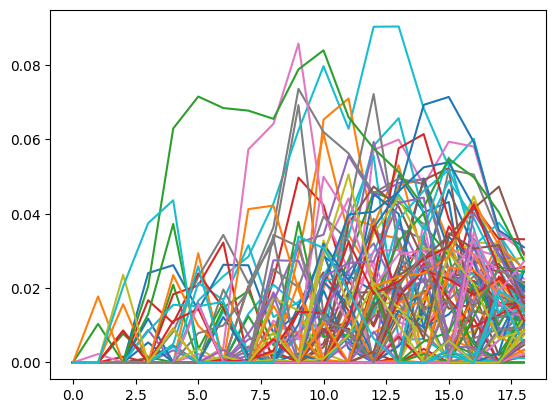

In [35]:
T_m = 10.0       # Maximum duration of swaption (Maturity)
pay_rate = 0.5  # Semi-Annual settlements (First settlement is assumed to be possible after this period too)
K = 0.045    # Strike rate
N = 1       # Notional Amount
short_rate_paths    # Already simulated paths for short rates

simulations_swap_values = []            # Change it later to numpy array for consistency
for simulation in range(simulations):
    # Finding Swap Value for each possible exercise point
    swap_values = []
    for T_0 in np.arange(0.0, T_m-pay_rate, pay_rate):     # Because of delay on starting of payments, we have less entries (Last one must be 2 pay_rates before Maturity9)
        swap_values.append(V(T_0, T_0+pay_rate, T_m, N, K, pay_rate, short_rate_paths[simulation]))
    simulations_swap_values.append(swap_values)

simulations_swap_values = np.array(simulations_swap_values) # Simplier to deal with np.arrays later on

plt.plot(simulations_swap_values.T)

In [36]:
from sklearn.linear_model import LinearRegression

# Extracting short rates of interest for the prediction (Should we actually use short rates from simulation???)
forward_rate_paths_regression = []
for simulation in range(simulations):
    forward_rates_of_interest = []
    for t in np.arange(0.0, T_m-pay_rate, pay_rate):
        # To be clear what is counted where, made variables as explicit as possible
        start_id = int(days_per_year*t)
        finish_id = int(days_per_year*(t+pay_rate))
        forward_rate = np.sum(short_rate_paths[simulation, start_id:finish_id]*dt)  # Using Reimann sum to approximate the integral for rates
        forward_rates_of_interest.append(forward_rate)
    forward_rate_paths_regression.append(forward_rates_of_interest)
forward_rate_paths_regression = np.array(forward_rate_paths_regression)         # r_s for Regression

time_between_payoff = days_per_year*pay_rate*dt
# Regressing and Finding optimal points to enter swap with prices
for i in reversed(range(0, simulations_swap_values.shape[1]-1)):
    ids_to_fit = np.where(simulations_swap_values[:, i] > 0)        # Creating mask to regress only "in money" options
    ids_to_fit = ids_to_fit[0]
    if np.any(ids_to_fit):
        Y = simulations_swap_values[ids_to_fit, i+1]*np.exp(-forward_rate_paths_regression[ids_to_fit, i]*pay_rate).reshape(-1,1)      # Target (V(t+1)*exp(-r_s(t)*dt)), assumed here dt is payoff_rate 
        X_pred = forward_rate_paths_regression[ids_to_fit, i].reshape(-1,1)                                                   # Train  (r_s(t))
        model = LinearRegression().fit(X_pred, Y)                               # For now it is just 1d linear regression, should try polynomial and more time entries to improve accuracy
        continuation_values = model.predict(simulations_swap_values[ids_to_fit, i].reshape(-1,1))
        continuation_values = continuation_values[0]        # Return of regression is duplicated, because it is 1D

        for j in range(continuation_values.shape[0]):
            #print(continuation_values[j], " vs ", simulations_swap_values[ids_to_fit[j], i])
            if continuation_values[j] > simulations_swap_values[ids_to_fit[j], i]:
                simulations_swap_values[ids_to_fit[j],i] = 0.0
            else: simulations_swap_values[ids_to_fit[j],i+1:] = 0.0

print(simulations_swap_values)

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.02356498 ... 0.         0.         0.        ]
 [0.         0.         0.02040047 ... 0.         0.         0.        ]]


In [37]:
fair_values_t = []
for sim in range(simulations):
    max_index = np.argmax(simulations_swap_values[sim])
    max_value = simulations_swap_values[sim][max_index]
    disc_rate = forward_rate_paths_regression[sim, max_index]
    max_value_fair = max_value*np.exp(-disc_rate*(max_index*pay_rate))        # dt cancels with days per year, obviously
    fair_values_t.append(max_value_fair)
fair_value_t = np.mean(fair_values_t)
print("Bermudan Swaption Value Fair Value is: ", fair_value_t)

Bermudan Swaption Value Fair Value is:  0.01589757847469248
